# Experimental Particle Physics Techniques: MPAGS Project
First task was to reconsturct the track of the muons along the x-z plane and estimate their momentum. Then produce a distribution of the reconstructed momentum and to find the resolution on the momentum value.

In [1]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [2]:
with up.open("../100GeV_0.5T.root:B5") as f:
    df = f.arrays(f.keys(), library="np")

# Also get the dataset with 100 GeV but a stronger magnetic field, should be better resolution due to larger bending
with up.open("../100GeV_1.0T.root:B5") as f:
    bf = f.arrays(f.keys(), library="np")

# Method 1: Two separate linear fits
Perform a fit to all the hits in the first detector arm and seperately the second detector arm. From these we can extract an angle of intercept.

In [3]:
# Degree of fitting polynomial 
deg = 1
m1, m2 = [], []

for i in range(df["Dc1HitsVector_x"].shape[0]):
    x1 = df["Dc1HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z1 = df["Dc1HitsVector_z"][i]*0.5*1.E+3
    x2 = df["Dc2HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z2 = df["Dc2HitsVector_z"][i]*0.5*1.E+3
    p = np.polyfit(z1, x1, deg)
    m, c = p[0], p[1]
    m1.append(m)
    p = np.polyfit(z2, x2, deg)
    m, c = p[0], p[1]
    m2.append(m)
m1 = np.array(m1)
m2 = np.array(m2)

In [4]:
m21, m22 = [], []

for i in range(bf["Dc1HitsVector_x"].shape[0]):
    x1 = bf["Dc1HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z1 = bf["Dc1HitsVector_z"][i]*0.5*1.E+3
    x2 = bf["Dc2HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z2 = bf["Dc2HitsVector_z"][i]*0.5*1.E+3
    p = np.polyfit(z1, x1, deg)
    m, c = p[0], p[1]
    m21.append(m)
    p = np.polyfit(z2, x2, deg)
    m, c = p[0], p[1]
    m22.append(m)
m21 = np.array(m21)
m22 = np.array(m22)

In [5]:
# Now find the angle between two straight lines, easy geometry here
dthetas = []
for grad1, grad2 in zip(m1, m2):
    dtheta = np.arctan(np.abs((grad1-grad2)/(1-(grad1*grad2))))
    dthetas.append(dtheta)

dthetas2 = []
for grad1, grad2 in zip(m21, m22):
    dtheta = np.arctan(np.abs((grad1-grad2)/(1-(grad1*grad2))))
    dthetas2.append(dtheta)
# This is clearly a very slow way to do all this but it is spaced out so it is easy to read

In [6]:
def get_pT(dtheta, B_FIELD_STRENGTH=0.5, LENGTH_IN_B_FIELD=2.0):
    return 0.3*B_FIELD_STRENGTH*LENGTH_IN_B_FIELD / dtheta

def gauss(x, mu, sigma, scale):
    return scale*np.exp(-((x-mu)**2)/(sigma**2))

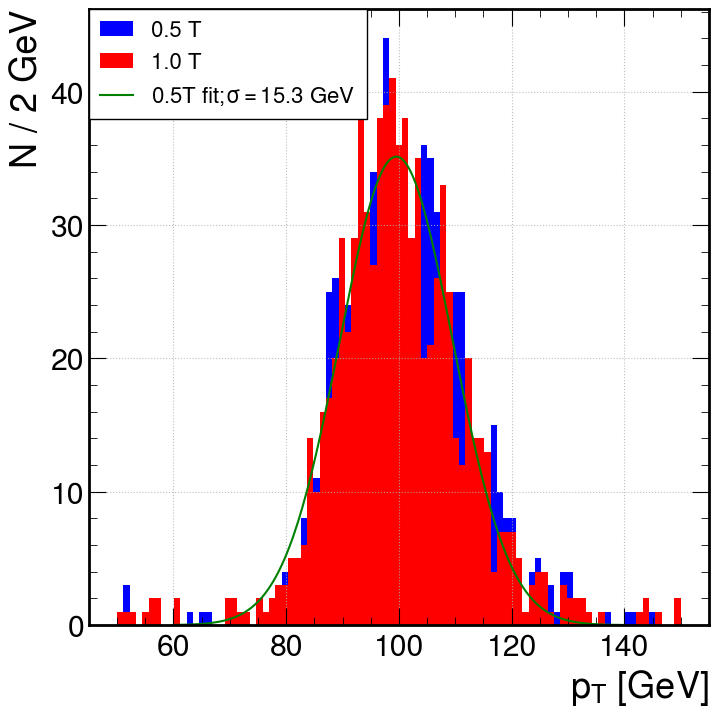

In [7]:
# Calculate and plot a distribution of the calculated pT values
from scipy.optimize import curve_fit
h, bins = np.histogram(get_pT(np.array(dthetas)), bins=np.linspace(50, 150, 90))
h2, _ = np.histogram(get_pT(np.array(dthetas2), 1.0), bins=bins)

centres = np.array([(bins[i]+bins[i+1])/2 for i in range(bins.shape[0]-1)])
popt, pcov = curve_fit(gauss, centres, h, p0=[100, 5, 50])

# above is a *very* crude but it works well enough gives us a rough idea of our resolution
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
hep.histplot(h, bins=bins, ax=ax, label='0.5 T', histtype='fill', color="blue")
hep.histplot(h2, bins=bins, ax=ax, label='1.0 T', histtype='fill', color="red")
plt.plot(np.linspace(60, 140, 200), gauss(np.linspace(60,140,200), *popt), label=r"0.5T fit;$\sigma=15.3$ GeV", color="green")
plt.grid()
plt.ylabel('N / 2 GeV')
plt.xlabel(r'$p_T$ [GeV]')
l = plt.legend(fontsize=16, frameon=True, edgecolor="#000", fancybox=False, borderaxespad=0, loc="upper left")
l.get_frame().set_alpha(1)
plt.show()

Don't need to do a fit, we can see the resolution increase would be very small. From this I conclude that at the moment the limiting factor is my analysis e.g. uncertainties introduced in the fitting process. 

In [8]:
# Let's calculate the chi2 of this fit as well to get an idea of how good/bad it is, we can see the distribution isn't really very gaussian
chi2 = np.sum((h-gauss(centres, *popt))**2/(1/np.sqrt(h)))
chi2_reduced = chi2 / (h.shape[0] - 2) # dof = n(obs) - n(params)
chi2_reduced # ouch...not great

/tmp/ipykernel_2462210/3963474808.py:2: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum((h-gauss(centres, *popt))**2/(1/np.sqrt(h)))


47.80653209936816

Again we would expect for the same magnetic field but lower momentum muons that the resolution increases since the radius of curvature in the magnetic field would decrease, i.e. the angle of deflection would be larger.

# Method 2: Global fit
In this method we exploit the fact that for some given momentum (and mass) we know what the curvature should be in the magnetic field. Therefore we know where our particle "should" exit the field given we know where it enters. Hence we can perform a global fit incorporating these facts.

In [357]:
def get_x_position(zs, pT, m0, c0):
    # With a known momentum, initial gradient and initial intercept the entire problem is well defined
    # z (arr) [m], pT (float) [GeV], m0 (float), c0 (float) [m]
    x_pos = []
    theta = np.arctan2(1, m0) # Positive theta value for gradient m0 (assumes m0 > 0)
    magnetic_field_strength = 1.0 # [T]
    electric_charge = 1.60217663E-19
    pT_SI = pT * 5.36E-19 # Convert [GeV/c] to [kg m/s]
    #gamma = np.sqrt(pT**2 + (105.7E-3)**2) / 105.7E-3 # All units used are in GeV, gamma = E / m
    radius_curvature = (pT_SI / (magnetic_field_strength * electric_charge)) # assumes no change in momentum during magneitc field
    dz = radius_curvature*np.cos(theta)
    if m0 < 0:
        dz *= -1
    circle_centre = np.array([-1+dz, ((-1*m0)+c0)-np.abs(radius_curvature*np.sin(theta))]) # particle always curved towards -ve x
    dx = np.sqrt(radius_curvature**2 - ((1 - circle_centre[0])**2))
    field_exit = np.array([1, circle_centre[1] + dx])
    gradient_exit = -1 / (dx / (1 - circle_centre[0]))
    for z in zs:
        if z <= -1:
            x_pos.append((z*m0) + c0)
        else:
            c1 = field_exit[1] - gradient_exit
            x_pos.append((z*gradient_exit)+c1)
    return np.array(x_pos)

ztrue = np.array([-6.25, -5.75, -5.25, -4.75, -4.25, 2.25, 2.75, 3.25, 3.75, 4.25]) # [m]

In [358]:
xtrue = np.concatenate([bf['Dc1HitsVector_x'][0], bf['Dc2HitsVector_x'][0]])*1E-3 # return value of func is [m]
def get_model_chi2(pT, m0, c0):
    return np.sum((xtrue - get_x_position(ztrue, pT, m0, c0))**2/np.abs(xtrue))

In [359]:
p = np.linspace(50, 150, 200)
chi2 = get_model_chi2(p, 1.173E-5, 4.58E-5)

/tmp/ipykernel_4059245/2708136478.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  field_exit = np.array([1, circle_centre[1] + dx])
/tmp/ipykernel_4059245/2708136478.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_pos)


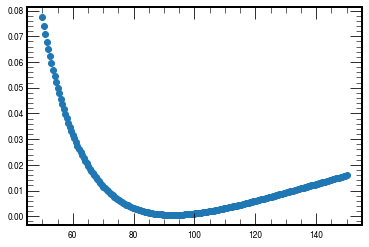

In [360]:
plt.scatter(p, chi2) # Look's like the problem is indeed well-defined
plt.show()

In [361]:
from iminuit import Minuit

m = Minuit(get_model_chi2, pT=100, m0=1.0E-5, c0=5.0E-5)

In [362]:
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.95e-05                   │              Nfcn = 53               │
│ EDM = 2.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ pT   │  0.09e3   │  0.30e3   │            │            │         │         │       │
│ 1 │ m0   │  0.0000   │  0.0019   │            │            │         │         │       │
│ 2 │ c0   │   0.000   │   0.011   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       pT       m0       c0 │
├────┼────────────────────────────┤
│ pT │ 9.12e+04   -0.151   -0.863 │
│ m0 │   -0.151 3.74e-06 2.12e-05 │
│ c0 │   -0.863 2.12e-05 0.000122 │
└────┴────────────────────────────┘

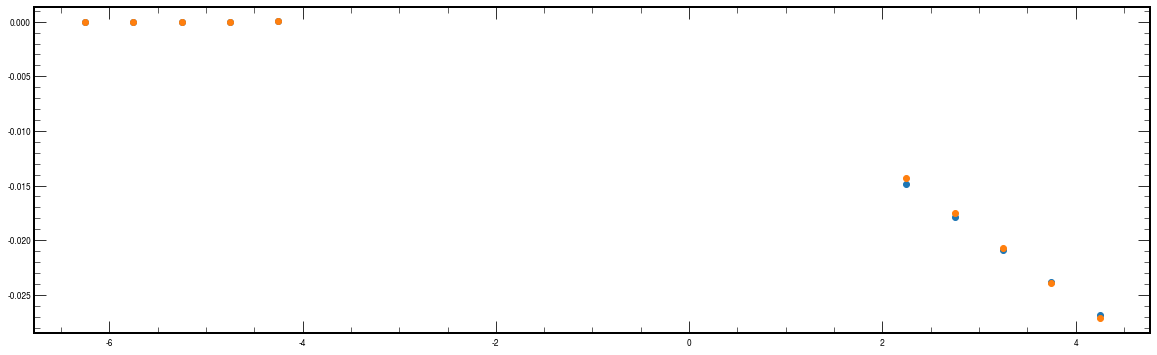

In [347]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(ztrue, xtrue)
plt.scatter(ztrue, get_x_position(ztrue, *m.values))
plt.show()

In [363]:
# OKay that's proof of the pudding - everything seems to work, now let's run over all our events and get a distribution
# for pT

pTs = []
for i in range(0, 1000):
    xtrue = np.concatenate([bf['Dc1HitsVector_x'][i], bf['Dc2HitsVector_x'][i]])*1E-3 # return value of func is [m]
    if xtrue.shape[0] != 10:
        continue
    def get_model_chi2(pT, m0, c0):
        return np.sum((xtrue - get_x_position(ztrue, pT, m0, c0))**2/np.abs(xtrue))
    m = Minuit(get_model_chi2, 100, 1.0E-5, 5.0E-5) # very rough initial parameter values
    m.migrad()
    m.hesse()
    pTs.append(m.values[0])

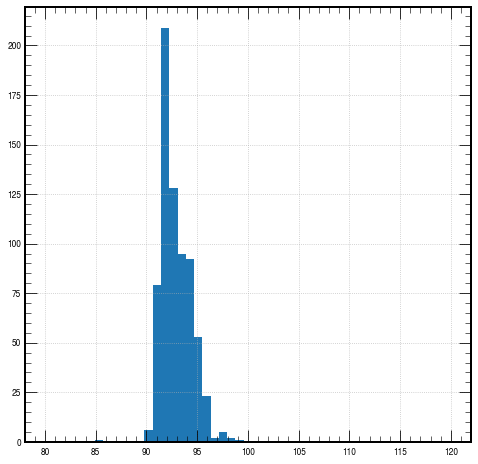

In [364]:
fig = plt.figure(figsize=(8,8))
plt.hist(pTs, bins=np.linspace(80, 120, 50))
plt.grid()
plt.show()